In [1]:
! git clone https://github.com/coin-dataset/annotations

Cloning into 'annotations'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 44 (delta 2), reused 9 (delta 2), pack-reused 34
Unpacking objects: 100% (44/44), done.


In [2]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.3 MB/s eta 0:00:00


In [3]:
! pip install decord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 42.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd
import json
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import numpy as np
import traceback
import logging
import re
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy
import gc
from sklearn.metrics import f1_score  
from sklearn import svm

In [6]:
import os
from subprocess import getoutput
getoutput("git clone -l -s https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch")
os.chdir('Video-Dataset-Loading-Pytorch')
import video_dataset
from video_dataset import VideoFrameDataset, ImglistToTensor
from video_dataset import VideoRecord


In [7]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification
from transformers import VideoMAEImageProcessor, VideoMAEModel
from huggingface_hub import hf_hub_download
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# Unzip prepared embeding
! unzip /content/gdrive/MyDrive/data.zip

Archive:  /content/gdrive/MyDrive/data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/COINagg.csv  
  inflating: data/train/COINnoagg.csv  
   creating: data/test/
  inflating: data/test/COINagg.csv   
  inflating: data/test/COINnoagg.csv  


In [ ]:
def prep(video):
 
  im = np.array([np.array(i) for i in video])

  return im

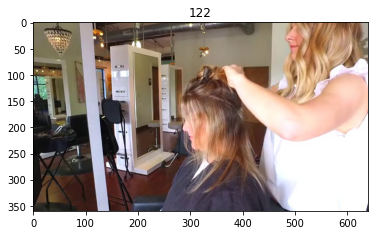

tensor([167])

Video Batch Tensor Size: torch.Size([1, 16, 360, 640, 3])
Batch Labels Size: torch.Size([1])


In [ ]:
from IPython.core.display import Image
preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(224),  # image batch, resize smaller edge to 224
        transforms.CenterCrop(224),  # image batch, center crop to square 224x224
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

dataset_testing = VideoFrameDataset(
    root_path='/content/gdrive/MyDrive/videos/testing/',
    annotationfile_path='/content/gdrive/MyDrive/videos/testing/ann_test.txt',
    num_segments=16,
    frames_per_segment=1,
    imagefile_template='{:05d}.jpg',
    transform=prep,
    test_mode=False
)

dataloader_testing = torch.utils.data.DataLoader(
        dataset=dataset_testing,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

sample = dataset_testing[0]  # take first sample of dataset 
frames = sample[0]   # list of PIL images
label = sample[1]    # integer label

for image in frames:
    
    plt.imshow(image)
    plt.title(label)
    plt.show()
    plt.pause(1)
    break
    


for epoch in range(5):
        for video_batch, labels in dataloader_testing:
            """
            Insert Training Code Here
            """
            print(labels)
            print("\nVideo Batch Tensor Size:", video_batch.size())
            print("Batch Labels Size:", labels.size())
            break
        break


Dataset Warning: video /content/gdrive/MyDrive/videos/training/13/00004 has 15 frames but the dataloader is set up to load (num_segments=16)*(frames_per_segment=1)=16 frames. Dataloader will throw an error when trying to load this video.


Dataset Warning: video /content/gdrive/MyDrive/videos/training/127/00004 has 15 frames but the dataloader is set up to load (num_segments=16)*(frames_per_segment=1)=16 frames. Dataloader will throw an error when trying to load this video.



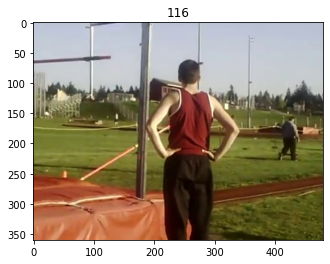

tensor([34])

Video Batch Tensor Size: torch.Size([1, 16, 360, 480, 3])
Batch Labels Size: torch.Size([1])


In [ ]:
dataset_training = VideoFrameDataset(
    root_path='/content/gdrive/MyDrive/videos/training/',
    annotationfile_path='/content/gdrive/MyDrive/videos/training/ann_train.txt',
    num_segments=16,
    frames_per_segment=1,
    imagefile_template='{:05d}.jpg',
    transform=prep,
    test_mode=False
)

dataloader_training = torch.utils.data.DataLoader(
        dataset=dataset_training,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

sample = dataset_training[0]  # take first sample of dataset 
frames = sample[0]   # list of PIL images
label = sample[1]    # integer label

for image in frames:
    
    plt.imshow(image)
    plt.title(label)
    plt.show()
    plt.pause(1)
    break


for epoch in range(5):
        for video_batch, labels in dataloader_training:
            """
            Insert Training Code Here
            """
            print(labels)
            print("\nVideo Batch Tensor Size:", video_batch.size())
            print("Batch Labels Size:", labels.size())
            break
        break

In [9]:
# Convert frames to VideoMAE embeddings and save it as csv file

def get_embeddings(dataloader, prefix, model_name='MCG-NJU/videomae-base'):
  image_processor = VideoMAEImageProcessor.from_pretrained(model_name)
  model = VideoMAEModel.from_pretrained(model_name)

  data = {
      'label': [],
      'embedding': []
  }
  
  i = 0
  for video, label in dataloader:

    # Saving - main operation
    if i % 100 == 0 and i != 0:
      data = pd.DataFrame(data)
      data.to_csv(f'/content/gdrive/MyDrive/embed{str(i)}_{str(prefix)}.csv')
      data = {'label': [],'embedding': []}

    print(i)
    i += 1

    video = video.squeeze(0)
    inputs = image_processor(list(video), return_tensors="pt")
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    emb = last_hidden_states[0][0].detach().numpy()
    data['label'] += [label]
    data['embedding'] += [emb]
    gc.collect()

  return pd.DataFrame(data)

In [10]:
# Convert from csv file into dataframe and extract embeddings into numpy matrix
def convert_to_single_frame(key_words, path):

  word1 = key_words[0]
  word2 = key_words[1]
  data_train = []

  for tr in os.listdir(path):

    if word1 in tr and word2 in tr:
      data_train.append(pd.read_csv(f'{path}/{tr}'))

  dt_train = pd.concat(data_train).reset_index()

  spisok_floats = []
  for s in dt_train['emb']:
    
    s = s.replace('[', '').replace(']', '').replace(',', '')
    
    floats = np.array([float(x) for x in s.split()])
    spisok_floats.append(floats)

  
  dt_train['embed_digits'] = spisok_floats

  return dt_train, np.array(spisok_floats)


In [11]:
key_words_train = ['train', 'train']
dt_train, spisok_train = convert_to_single_frame(key_words=key_words_train, path='/content/gdrive/MyDrive/data/train')

key_words_test = ['test', 'test']
dt_test, spisok_test = convert_to_single_frame(key_words=key_words_test, path='/content/gdrive/MyDrive/data/test')


In [12]:
# Convert x data into torch tensor and extract y data from dataframes
y_train, y_test = dt_train.cls.values.tolist(), dt_test.cls.values.tolist()
x_train, x_test = torch.from_numpy(spisok_train), torch.from_numpy(spisok_test)
x_train, x_test = x_train.to(torch.float32), x_test.to(torch.float32)


In [13]:
# Convert y data into torch tensor
tr, tes = [], []
for l_tr in y_train:
  
  digits_train = l_tr
  tr.append(int(digits_train))

for l_tes in y_test:
  
  digits_test = l_tes
  tes.append(int(digits_test))

y_train, y_test = torch.tensor(tr), torch.tensor(tes)

In [14]:
# Create common amount of data in order to alleviate further dividing into train/test dataset
X = torch.cat((x_train, x_test), 0)
Y = torch.cat((y_train, y_test), 0)

In [15]:
x_train, y_train = X[0:7642], Y[0:7642]
x_test, y_test = X[7642:], Y[7642:]
print(x_test.shape, x_train.shape)

torch.Size([2351, 1024]) torch.Size([7642, 1024])


In [105]:
class Net1(nn.Module):
    def __init__(self):
      super(Net1, self).__init__()
      self.n1 = nn.LayerNorm(1024, elementwise_affine=True)
      self.fc1 = nn.Linear(1024, 250)
      self.n2 = nn.LayerNorm(250, elementwise_affine=True)
      self.fc2 = nn.Linear(250, 100)
      self.n3 = nn.LayerNorm(100, elementwise_affine=True)
      self.fc3 = nn.Linear(100, 180)
      

    # x represents our data
    def forward(self, x):
      
      # Pass data through fc1
      x = self.n1(x)
      x = self.fc1(x)
      x = F.gelu(x)
      x = self.n2(x)
      x = self.fc2(x)
      x = F.gelu(x)
      x = self.n3(x)
      x = self.fc3(x)
     
 
      return x

class Net2(nn.Module):
    def __init__(self):
      super(Net2, self).__init__()
  
      self.fc1 = nn.Linear(1024, 1024)
      self.fc2 = nn.Linear(1024, 1024)
      self.fc3 = nn.Linear(1024, 1024)
      self.fc4 = nn.Linear(1024, 512)
      self.fc5 = nn.Linear(512, 180)

    # x represents our data
    def forward(self, x):
      
      # Pass data through fc1
      
      x = self.fc1(x)
      x = F.gelu(x)
      x = self.fc2(x)
      x = F.gelu(x)
      x = self.fc3(x)
      x = F.gelu(x)
      x = self.fc4(x)
      x = F.gelu(x)
      x = self.fc5(x)
     
 
      return x

In [120]:
network = Net2()
network.to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(network.parameters(), lr=0.00001, betas = (0.9, 0.9))

In [121]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, f1, dir):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"{dir}/accuracy.png")
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"{dir}/loss.png")

    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        f1, color='red', linestyle='-', 
        label='F1'
    )

    
    plt.xlabel('Epochs')
    plt.ylabel('F1_macro')
    plt.legend()
    plt.savefig(f"{dir}/F1_macro.png")

--------------------------------------------------
EPOCH 0
TRAIN: loss = 5.2016801834106445, accuracy = 0.3925674259662628
VAL: loss = 5.19617223739624, accuracy = 0.29774564504623413
f1 =  0.0004157211216847191
--------------------------------------------------
EPOCH 1
TRAIN: loss = 5.1987385749816895, accuracy = 0.3925674259662628
VAL: loss = 5.193848609924316, accuracy = 0.38281580805778503
f1 =  0.0011555026537172167
--------------------------------------------------
EPOCH 2
TRAIN: loss = 5.195847511291504, accuracy = 0.5234231948852539
VAL: loss = 5.191568374633789, accuracy = 0.3402807414531708
f1 =  0.0009840241000410627
--------------------------------------------------
EPOCH 3
TRAIN: loss = 5.193005084991455, accuracy = 0.5365087389945984
VAL: loss = 5.189325332641602, accuracy = 0.552956223487854
f1 =  0.001653097548063759
--------------------------------------------------
EPOCH 4
TRAIN: loss = 5.190206527709961, accuracy = 0.5495943427085876
VAL: loss = 5.187117099761963, ac

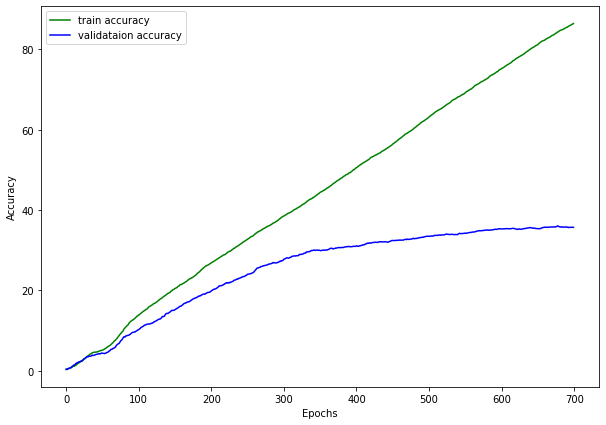

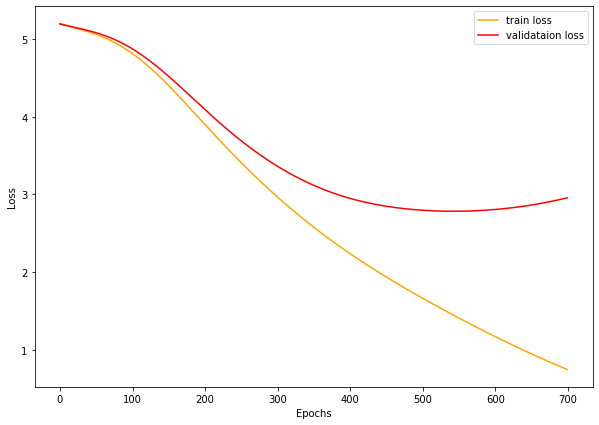

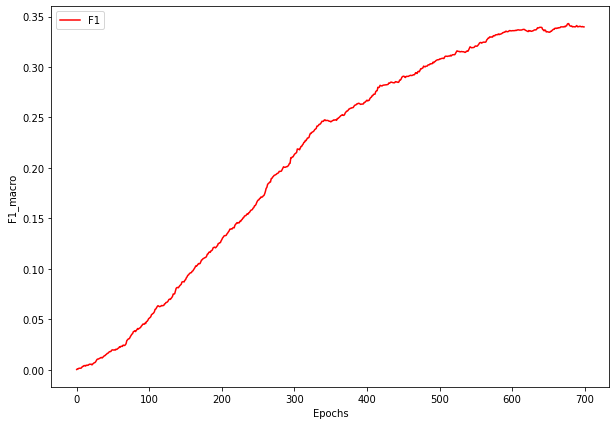

In [122]:
data = dict(train=(x_train, y_train), val=(x_test, y_test))
metrics = dict(train=([], []), val = ([], [], []))
best_loss, best_f1 =  5, -100
for i in range(700):
  print(50*'-')
  print("EPOCH", i)
  for phase in ['train', 'val']:

    x, y = data[phase]
    x, y = x.to(device), y.to(device)
    
    running_corrects = 0
    opt.zero_grad()
    out = network(x)
    _, preds = torch.max(out, 1)
    loss = criterion(out, y)

    if phase == 'train':
      loss.backward()
      opt.step()

    running_corrects += torch.sum(preds == y.data)
    accuracy = running_corrects/preds.shape[0] * 100

    print(f'{phase.upper()}: loss = {loss}, accuracy = {accuracy}')

    metrics[phase][0].append(accuracy.cpu())
    metrics[phase][1].append(loss.detach().cpu())

  f1 = f1_score(np.array(y.cpu()), np.array(preds.cpu()), average='macro')
  metrics[phase][2].append(f1)

  if f1 > best_f1:

      best_f1 = f1

  print('f1 = ', f1)

print(f'Best val f1: {best_f1:4f}')
train_acc, train_loss = metrics['train']
val_acc, val_loss, val_f1 = metrics['val']
save_plots(train_acc, val_acc, train_loss, val_loss, val_f1, dir='/content/gdrive/MyDrive/Embed_results_NN')


In [112]:
SVM = svm.SVC(C = 5, max_iter=500)

In [113]:
SVM.fit(x_train, y_train)

SVC(C=5, max_iter=500)

In [114]:
acc = SVM.score(x_test, y_test)
acc

0.26485213294948967